# Load audio data to array numpy

In [1]:
import os
import librosa

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

audio_files = {}

for g in genres:
  audio_files[g] = []

for g in genres:
  for audio in os.listdir(f'./genres/{g}'):
    # Audio loaded as [ndarray, float]
    audio_files[g].append(librosa.core.load(f'./genres/{g}/{audio}'))

# Preprocessing

In [2]:
import numpy as np
from sklearn.decomposition import PCA

mel_specs = []

for g in genres:

  for audio in audio_files[g]:

    y = audio[0]
    sr = audio[1]

    # Generate log power spectrogram
    S = np.abs(librosa.stft(y))
    spect = librosa.power_to_db(S**2, ref=np.median)

    # Slice to have same shapes for all
    spect = spect[:1000,:1220]

    # Compress for the model
    new_shape = (500,610)
    block_height = spect.shape[0] // new_shape[0]
    block_width = spect.shape[1] // new_shape[1]
    downsampled_array = spect.reshape(new_shape[0], block_height, new_shape[1], block_width).mean(3).mean(1)

    mel_specs.append(downsampled_array)
        
X = np.array(mel_specs)

# See images generated

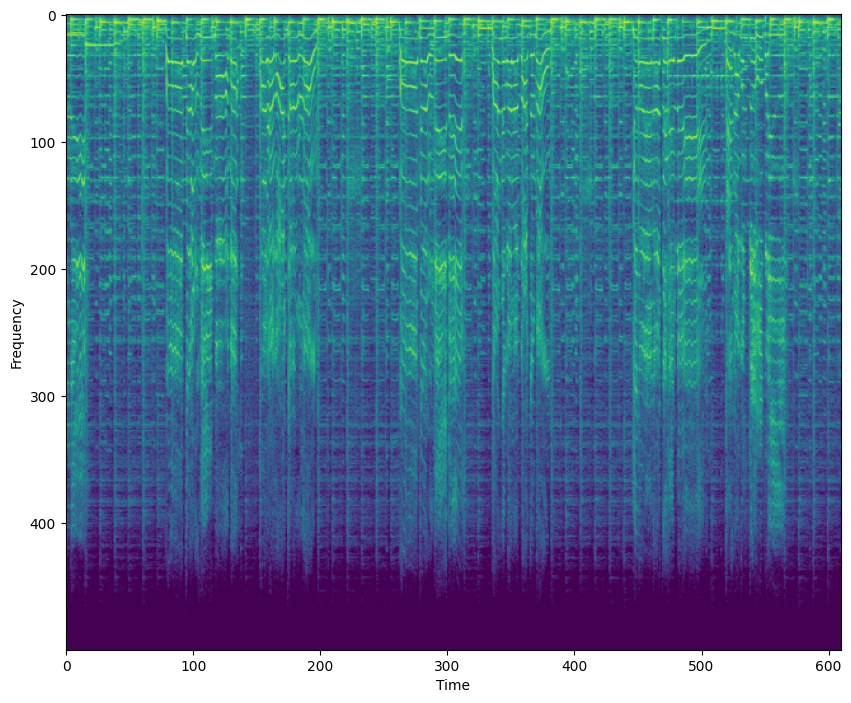

In [3]:
import matplotlib.pyplot as plt

# Specify the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Add x and y axis titles
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')

# Display the image
ax.imshow(mel_specs[2])

# Show the plot
plt.show()

# Train test split

### Import

In [4]:
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2023-08-08 20:25:30.745826: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 20:25:30.776315: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 20:25:30.776787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 20:25:31.429341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Create y 

In [5]:
# TODO: Delete duplicated jazz sample (54)
y_cnn = []
for i in range(len(genres)):
  y_cnn += 100*[i] # On a 100 images pour chaque genre

y_cnn = to_categorical(np.array(y_cnn))

### Train test split

In [6]:
x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X, y_cnn, test_size=0.2)

# Model

### Neural networks layers

In [7]:
import tensorflow as tf

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(500, 610, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

2023-08-08 20:25:32.408479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-08 20:25:32.428221: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 608, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 304, 16)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1211136)           0         
                                                                 
 dense (Dense)               (None, 64)                77512768  
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 77513578 (295.69 MB)
Trainable params: 77513578 (295.69 MB)
Non-trainable params: 0 (0.00 Byte)
____________

### Compile

In [8]:
optimizer = tf.keras.optimizers.Adam() # learning_rate=0.0001

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

### Fit

In [11]:
history = model.fit(x_cnn_train,
                    y_cnn_train,
                    epochs=10,
                    batch_size=10,
                    validation_data = (x_cnn_test,y_cnn_test))

Epoch 1/10
80/80 [==============================] - 73s 917ms/step - loss: 9.5287 - accuracy: 0.1912 - val_loss: 2.3026 - val_accuracy: 0.1050
Epoch 2/10
80/80 [==============================] - 72s 899ms/step - loss: 2.3040 - accuracy: 0.1088 - val_loss: 2.3015 - val_accuracy: 0.1050
Epoch 3/10
80/80 [==============================] - 71s 888ms/step - loss: 2.2820 - accuracy: 0.1075 - val_loss: 2.3033 - val_accuracy: 0.1050
Epoch 4/10
80/80 [==============================] - 71s 892ms/step - loss: 2.2848 - accuracy: 0.1150 - val_loss: 2.2998 - val_accuracy: 0.1100
Epoch 5/10
80/80 [==============================] - 72s 895ms/step - loss: 2.2708 - accuracy: 0.1037 - val_loss: 2.3026 - val_accuracy: 0.1050
Epoch 6/10
80/80 [==============================] - 72s 895ms/step - loss: 2.2823 - accuracy: 0.1187 - val_loss: 2.2943 - val_accuracy: 0.0850
Epoch 7/10
80/80 [==============================] - 72s 896ms/step - loss: 2.2848 - accuracy: 0.1050 - val_loss: 2.3020 - val_accuracy: 0.0800

### Save

In [ ]:
# model.save("my_model_cnn_clean_v1.keras")

# Metrics

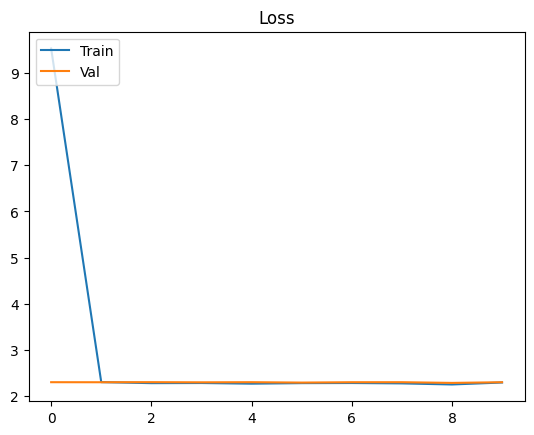

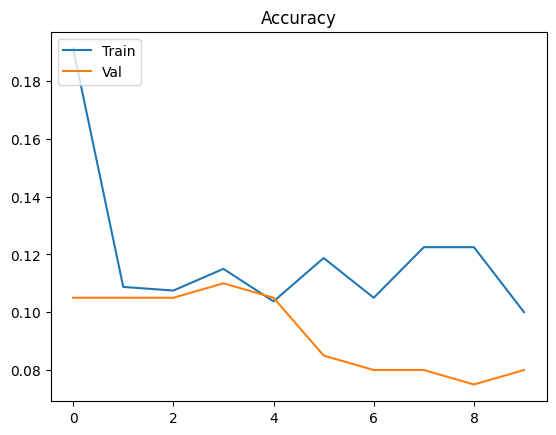

In [15]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

# Predict

### Preprocessing

In [ ]:
# audio = librosa.core.load(f'./genres/blues/blues.00000.wav')
# audio = librosa.core.load(f'./genres/blues/blues.00049.wav')
audio = librosa.core.load(f'./genres/disco/disco.00090.wav')
# audio = librosa.core.load(f'./genres/jazz/jazz.00097.wav')
y = audio[0]
sr = audio[1]

# Generate log power spectrogram
S = np.abs(librosa.stft(y))
spect = librosa.power_to_db(S**2, ref=np.median)

# Slice to have same shapes for all
spect = spect[:1000,:1220]

# Compress for the model
new_shape = (100,122)
block_height = spect.shape[0] // new_shape[0]
block_width = spect.shape[1] // new_shape[1]
downsampled_array = spect.reshape(new_shape[0], block_height, new_shape[1], block_width).mean(3).mean(1)

X = np.array([downsampled_array])

In [ ]:
result = model.predict(X, verbose=2)

1/1 - 0s - 15ms/epoch - 15ms/step


In [ ]:
actual_best = 0
result_label = ""

for i in range(len(genres)):
    actual = result[0][i]
    if actual > actual_best:
        actual_best = actual
        result_label = genres[i]

print(result_label, str(actual_best))

disco 0.9871753
